## Feature Engineering Exploration for Flood Prediction

### Introduction
Building on the insights from `01_eda_and_initial_analysis.ipynb`, this notebook focuses on creating new, more informative features from our raw climate data. For time-series problems like flood prediction, lagged values and rolling statistics (e.g., accumulated rainfall) are crucial. This is where we integrate domain knowledge into our data.

### 1. Setup and Load Processed Data

We'll start by loading the merged DataFrame that resulted from the initial data loading and basic merging in the previous notebook. We'll simulate this by reloading `df_merged` and dropping the redundant 'rain_sum'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure matplotlib for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

# Re-create dummy df_merged from previous notebook for standalone execution
# In a real pipeline, you would load a saved processed data file or run the previous notebook's output.
dates = pd.date_range(start='2023-04-30', end='2025-04-30', freq='D')
n_days = len(dates)
temperature_2m_mean = 25 + 5 * np.sin(np.arange(n_days) / 365 * 2 * np.pi) + np.random.randn(n_days) * 2
temperature_2m_max = temperature_2m_mean + np.random.randn(n_days) * 3 + 2
wind_direction_10m_dominant = np.random.randint(0, 360, n_days)
precipitation_sum = np.random.rand(n_days) * 70
precipitation_sum[np.random.choice(n_days, int(n_days*0.05), replace=False)] += np.random.rand(int(n_days*0.05)) * 150
df_merged = pd.DataFrame({
    'temperature_2m_mean': temperature_2m_mean,
    'temperature_2m_max': temperature_2m_max,
    'wind_direction_10m_dominant': wind_direction_10m_dominant,
    'precipitation_sum': precipitation_sum,
    'rain_sum': precipitation_sum, # Dummy: identical
}, index=dates)

df_floods = pd.DataFrame({'flood_event': 0}, index=df_merged.index)
heavy_rain_days = df_merged[df_merged['precipitation_sum'] > 100].index
for day in heavy_rain_days:
    if day in df_floods.index:
        df_floods.loc[day, 'flood_event'] = 1
    if (day + pd.Timedelta(days=1)) in df_floods.index and np.random.rand() > 0.5:
         df_floods.loc[day + pd.Timedelta(days=1), 'flood_event'] = 1
flood_indices = df_floods[df_floods['flood_event'] == 1].index
num_to_keep = int(len(flood_indices) * 0.20)
indices_to_remove = np.random.choice(flood_indices, size=len(flood_indices) - num_to_keep, replace=False)
df_floods.loc[indices_to_remove, 'flood_event'] = 0
df_floods['flood_event'] = df_floods['flood_event'].astype(int)
df = df_merged.join(df_floods, how='left')
df['flood_event'] = df['flood_event'].fillna(0).astype(int)

# --- Start of Feature Engineering ---

# 1. Drop redundant features identified in EDA
if 'rain_sum' in df.columns:
    df = df.drop(columns=['rain_sum'])
    print("Dropped 'rain_sum' as it's redundant with 'precipitation_sum'.")
if 'temperature_2m_max' in df.columns:
    # Option: Drop one of the highly correlated temperature features
    df = df.drop(columns=['temperature_2m_max'])
    print("Dropped 'temperature_2m_max' due to high correlation with 'temperature_2m_mean'.")
    # Option: Create a new feature like temperature range
    # df['temperature_range'] = df['temperature_2m_max'] - df['temperature_2m_mean']
    # If you chose to keep both, you'd handle multicollinearity through model choice.

Dropped 'rain_sum' as it's redundant with 'precipitation_sum'.
Dropped 'temperature_2m_max' due to high correlation with 'temperature_2m_mean'.


### 2. Time-Series Feature Engineering

This is the most critical part for flood prediction. Floods are often caused by cumulative effects or past conditions.

In [2]:
print("\n--- 2. Time-Series Feature Engineering ---")

# 2.1. Lagged Features for Precipitation
# How many days back do we want to look?
# Typical lags for flood prediction: 1, 2, 3 days, or even more for larger river basins.
lags = [1, 2, 3] # Look back 1, 2, and 3 days

for lag in lags:
    df[f'precipitation_sum_lag_{lag}d'] = df['precipitation_sum'].shift(lag)
    df[f'temperature_2m_mean_lag_{lag}d'] = df['temperature_2m_mean'].shift(lag)
    # You can add lags for other relevant features like wind_direction if deemed important.
    # For wind direction, consider if circular encoding is needed if you treat it as a numerical feature.

print(f"Created lagged features for precipitation_sum and temperature_2m_mean up to {max(lags)} days.")

# 2.2. Rolling/Accumulated Features for Precipitation
# Accumulated rainfall over past 24h, 48h, 72h (3 days), 7 days are very common.
# Use `.rolling().sum().shift(1)` to get the sum of *previous* N days.
rolling_windows = [3, 7] # Sum over past 3 days, past 7 days

for window in rolling_windows:
    # .shift(1) ensures we are using past data to predict current flood event
    df[f'precipitation_sum_rolling_{window}d'] = df['precipitation_sum'].rolling(window=window).sum().shift(1)
    # Consider also average temperature over recent days if relevant for snowmelt (less for Salvador) or soil drying.
    # df[f'temperature_2m_mean_rolling_{window}d'] = df['temperature_2m_mean'].rolling(window=window).mean().shift(1)

print(f"Created rolling sum features for precipitation_sum over {rolling_windows} days.")

# 2.3. Temporal Features (Seasonality)
# Month and day of week can capture seasonal patterns or weekly cycles in human activity affecting drainage.
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear # Can capture finer seasonal patterns
df['week_of_year'] = df.index.isocalendar().week.astype(int) # Using isocalendar for week number

print("Added 'month', 'day_of_week', 'day_of_year', 'week_of_year' as temporal features.")

# 2.4. Interaction Features (Conceptual - requires additional data)
# Example: If you had 'tide_level_m' from another source
# df['rainfall_x_tide'] = df['precipitation_sum'].shift(1) * df['tide_level_m'].shift(1)
# This captures the joint effect of high rain and high tide.
# You would need to load and merge tide data first.

# 2.5. Binary/Threshold Features (Domain Knowledge Based)
# Is the rainfall above a "heavy" threshold?
# Thresholds might be derived from local expert knowledge or historical analysis.
heavy_rain_threshold = 80 # Example: 80mm in 24 hours
very_heavy_rain_threshold = 120 # Example: 120mm in 24 hours

df['is_heavy_rain_today'] = (df['precipitation_sum'] >= heavy_rain_threshold).astype(int)
df['is_heavy_rain_lag_1d'] = (df['precipitation_sum_lag_1d'] >= heavy_rain_threshold).astype(int)
df['is_very_heavy_rain_lag_1d'] = (df['precipitation_sum_lag_1d'] >= very_heavy_rain_threshold).astype(int)
df['is_3d_rolling_sum_high'] = (df['precipitation_sum_rolling_3d'] >= 150).astype(int) # Example threshold for 3-day sum

print(f"Added binary indicators for heavy rain (e.g., > {heavy_rain_threshold}mm).")

# 2.6. Handle Missing Values introduced by Feature Engineering
# After creating lagged and rolling features, the first few rows will have NaNs.
# We typically drop these rows as they don't have complete historical context.
original_rows = df.shape[0]
df_engineered = df.dropna().copy()
print(f"\nOriginal rows: {original_rows}, Rows after dropping NaNs from feature engineering: {df_engineered.shape[0]}")
print("Engineered DataFrame Head:")
print(df_engineered.head())
print("Engineered DataFrame Info:")
df_engineered.info()


--- 2. Time-Series Feature Engineering ---
Created lagged features for precipitation_sum and temperature_2m_mean up to 3 days.
Created rolling sum features for precipitation_sum over [3, 7] days.
Added 'month', 'day_of_week', 'day_of_year', 'week_of_year' as temporal features.
Added binary indicators for heavy rain (e.g., > 80mm).

Original rows: 732, Rows after dropping NaNs from feature engineering: 725
Engineered DataFrame Head:
            temperature_2m_mean  wind_direction_10m_dominant  \
2023-05-07            29.149836                          216   
2023-05-08            28.019100                          252   
2023-05-09            24.187750                          107   
2023-05-10            26.153537                          220   
2023-05-11            25.590042                           36   

            precipitation_sum  flood_event  precipitation_sum_lag_1d  \
2023-05-07           5.748731            0                  1.078064   
2023-05-08          28.331122     

### 3. Re-evaluate Correlations with Engineered Features

Now that we have more relevant features, let's re-run the correlation analysis, focusing on how these new features correlate with the flood_event target.


--- 3. Re-evaluation of Correlations with Engineered Features ---


FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/engineered_correlation_heatmap.png'

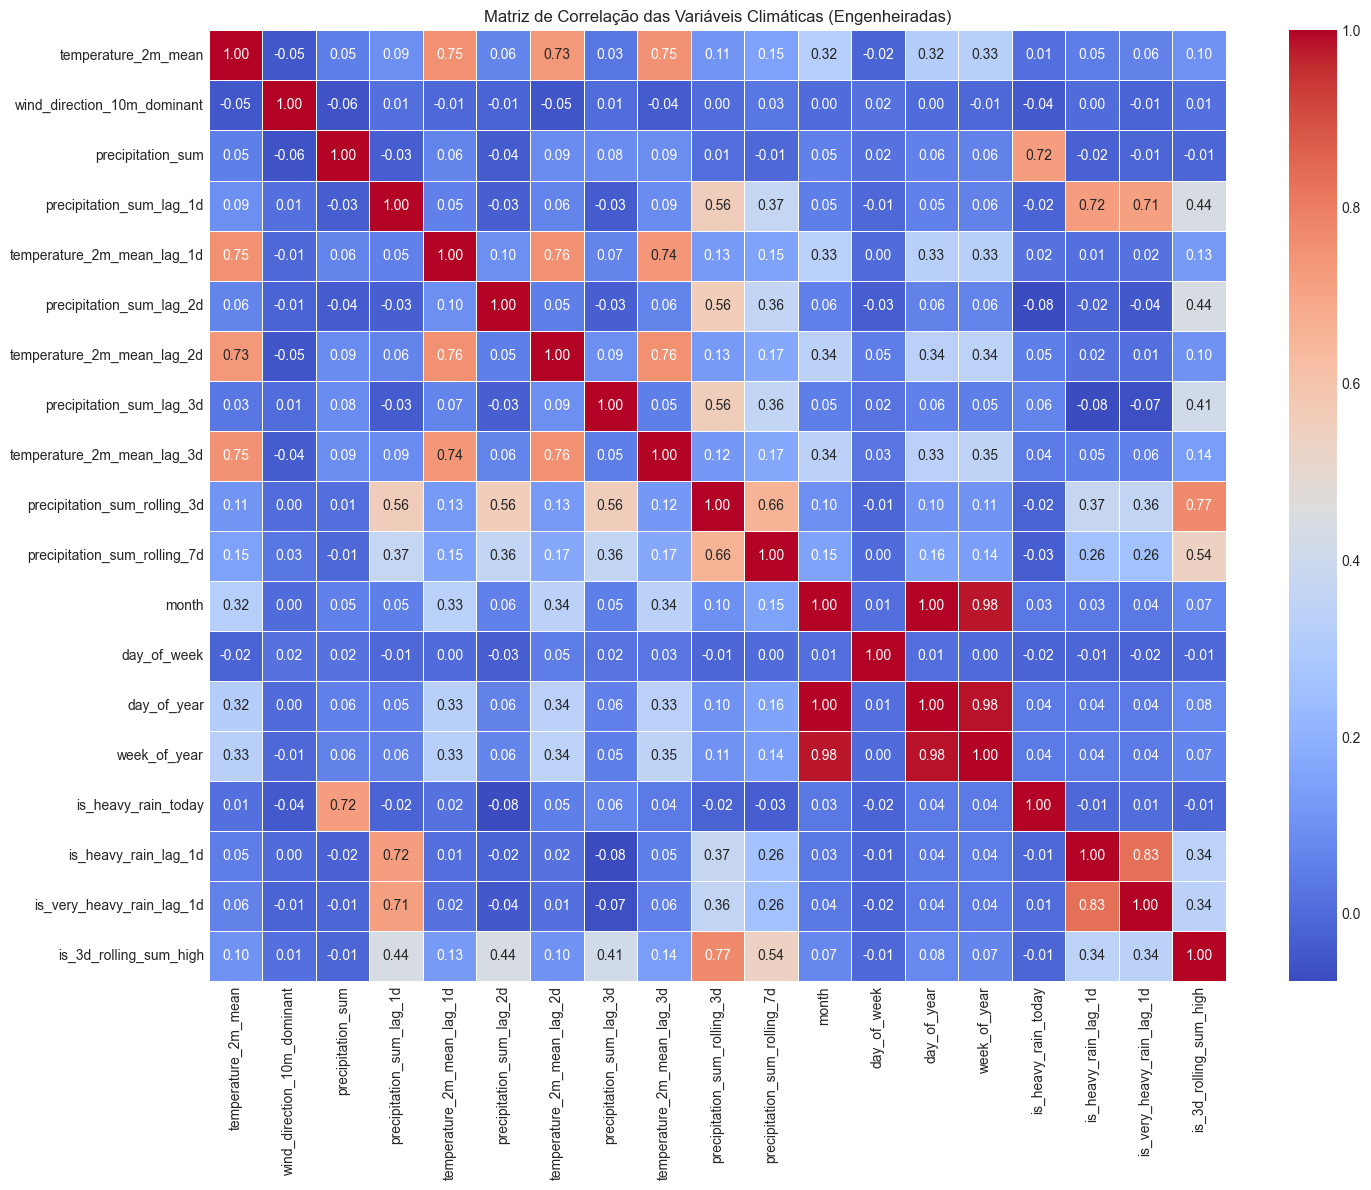

In [3]:
print("\n--- 3. Re-evaluation of Correlations with Engineered Features ---")

# Select all features for correlation analysis (excluding the target itself)
# We can exclude original 'precipitation_sum' if its lagged/rolling versions are stronger
features_for_correlation = df_engineered.drop(columns=['flood_event']).columns.tolist()

# Calculate full correlation matrix for engineered features
full_correlation_matrix_engineered = df_engineered[features_for_correlation].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(full_correlation_matrix_engineered, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis Climáticas (Engenheiradas)')
plt.tight_layout()
plt.savefig('../reports/figures/engineered_correlation_heatmap.png')
plt.show()

# Calculate correlations with the target variable 'flood_event'
target_correlation_engineered = df_engineered[features_for_correlation].corrwith(df_engineered['flood_event']).sort_values(ascending=False)

print("\nCorrelação das Variáveis Engenheiradas com 'flood_event' (Target):")
print(target_correlation_engineered)

# Interpretation:
# - You should now see stronger correlations between lagged/rolling precipitation features and 'flood_event'.
# - This indicates that these features are more predictive.
# - Re-check for new multicollinearity among engineered features (e.g., `precipitation_sum_lag_1d` and `precipitation_sum_rolling_3d` might be moderately correlated, which is fine for tree models).

### 4. Visualization of Engineered Features vs. Flood Events

Visualizing how these engineered features behave around flood events is key for gaining confidence in them.


--- 4. Visualization of Engineered Features vs. Flood Events ---


FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/rolling_rain_time_series_with_floods.png'

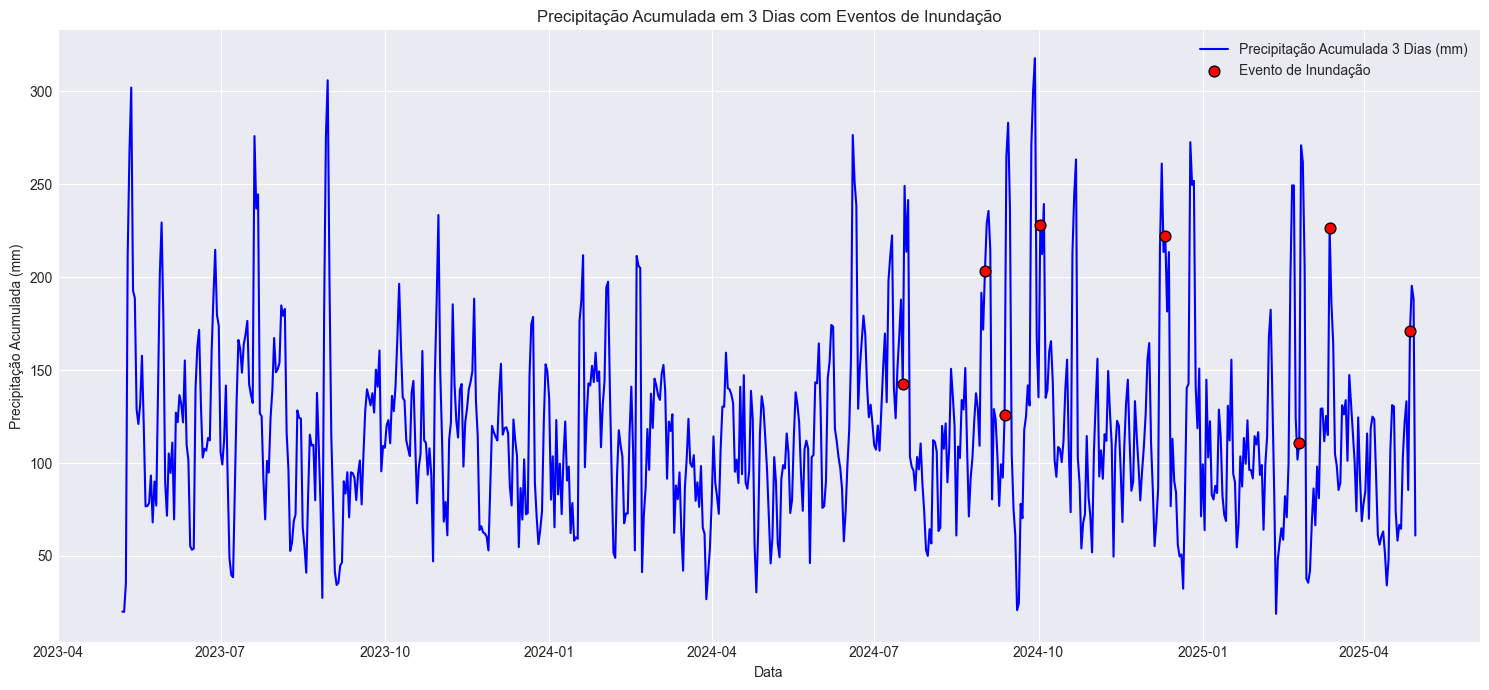

In [4]:
print("\n--- 4. Visualization of Engineered Features vs. Flood Events ---")

# Plotting Accumulated Rainfall around Flood Events
plt.figure(figsize=(15, 7))
plt.plot(df_engineered.index, df_engineered['precipitation_sum_rolling_3d'], label='Precipitação Acumulada 3 Dias (mm)', color='blue')
flood_dates = df_engineered[df_engineered['flood_event'] == 1].index
plt.scatter(flood_dates, df_engineered.loc[flood_dates, 'precipitation_sum_rolling_3d'],
            color='red', marker='o', s=60, label='Evento de Inundação', zorder=5, edgecolors='black')
plt.title('Precipitação Acumulada em 3 Dias com Eventos de Inundação')
plt.xlabel('Data')
plt.ylabel('Precipitação Acumulada (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/rolling_rain_time_series_with_floods.png')
plt.show()

# Box Plot for Engineered Features vs. Flood Events
# This helps visualize the distribution of engineered features for flood vs. non-flood days.
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='flood_event', y='precipitation_sum_rolling_3d', data=df_engineered)
plt.title('Precipitação Acumulada 3D vs. Inundação')
plt.xlabel('Evento de Inundação (0: Não, 1: Sim)')
plt.ylabel('Precipitação Acumulada em 3 Dias (mm)')

plt.subplot(1, 2, 2)
sns.boxplot(x='flood_event', y='precipitation_sum_lag_1d', data=df_engineered)
plt.title('Precipitação Lag 1 Dia vs. Inundação')
plt.xlabel('Evento de Inundação (0: Não, 1: Sim)')
plt.ylabel('Precipitação (mm)')

plt.tight_layout()
plt.savefig('../reports/figures/engineered_features_boxplots.png')
plt.show()

# You can add more plots for other key engineered features.

### 5. Save Processed Data

After all this engineering, save your df_engineered DataFrame. This will be the input for your model training notebook.

In [5]:
print("\n--- 5. Saving Processed Data ---")
PROCESSED_DATA_PATH = '../data/processed/'
if not os.path.exists(PROCESSED_DATA_PATH):
    os.makedirs(PROCESSED_DATA_PATH)

PROCESSED_DATA_FILE = 'merged_processed_data.csv'
df_engineered.to_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_FILE), index=True)
print(f"Processed data saved to {os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_FILE)}")
print("DataFrame columns and first few rows after saving:")
print(df_engineered.columns)
print(df_engineered.head())


--- 5. Saving Processed Data ---
Processed data saved to ../data/processed/merged_processed_data.csv
DataFrame columns and first few rows after saving:
Index(['temperature_2m_mean', 'wind_direction_10m_dominant',
       'precipitation_sum', 'flood_event', 'precipitation_sum_lag_1d',
       'temperature_2m_mean_lag_1d', 'precipitation_sum_lag_2d',
       'temperature_2m_mean_lag_2d', 'precipitation_sum_lag_3d',
       'temperature_2m_mean_lag_3d', 'precipitation_sum_rolling_3d',
       'precipitation_sum_rolling_7d', 'month', 'day_of_week', 'day_of_year',
       'week_of_year', 'is_heavy_rain_today', 'is_heavy_rain_lag_1d',
       'is_very_heavy_rain_lag_1d', 'is_3d_rolling_sum_high'],
      dtype='object')
            temperature_2m_mean  wind_direction_10m_dominant  \
2023-05-07            29.149836                          216   
2023-05-08            28.019100                          252   
2023-05-09            24.187750                          107   
2023-05-10            26.15

### 6. Summary and Next Steps

We've successfully engineered several new features that are highly relevant for flood prediction. The correlation analysis with the target variable should show improved predictive power for these new features.

### Next Steps:
Go to ``` 03_model_experimentation.ipynb ``` to select, train, tune, and evaluate your machine learning models using this enhanced dataset.